**Q2** Start with our imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
#from scipy.integrate import solve_ivp

Now define a function that computes the derivative of M and log(rho), when given an input r, M and log(rho).

In [2]:
def M_rho_deriv_degen(r_in_rsun, M_lrho, Z_on_A=0.5):
    """Find the Mass and density derivatives for solving a degenerate
    star equation of state problem. We have log(rho) as an input to help
    with numerics, as rho can never be negative.
    
    Parameters
    ----------
    M_lrho: numpy array-like, including M in solar units, rho in g/cm^3.
    
    Returns
    -------
    derivatives: Derivatives of M in solar units, log(rho in g/cm^3), with respect 
        to r_in_rsun, as a numpy array-like variable.
    """
    M_in_Msun, lrho = M_lrho
    
    #Lets create a variable rho in real units
    rho = np.exp(lrho)*u.g/u.cm**3
    
    #Mass continuity. Convert to dimensionless units
    dM_in_Msundr = float(4*np.pi*r_in_rsun**2*rho * c.R_sun**3/c.M_sun)
    
    #Fermi momentum
    p_F = ( c.h/2*(3*rho*Z_on_A/np.pi/u.u)**(1/3) ).cgs
    
    #dPdrho - should have units of (velocity)^2
    dPdrho = ( p_F**2*c.c/3/u.u/np.sqrt(p_F**2 + c.m_e**2*c.c**2) * Z_on_A ).cgs
    
    #drho/dr
    if r_in_rsun==0:
        dlrhodr = 0
    else:
        dlrhodr = -(c.G*M_in_Msun*c.M_sun/(r_in_rsun*c.R_sun)**2 / dPdrho)\
            .to(1/c.R_sun).value
    
    return np.array([dM_in_Msundr, dlrhodr])
    
#The following function may be slightly confusing for people who aren't python or 
#object oriented programming experts, as variables (properties) are added to a function. 
#We can actually always add additional properties to functions, as all variables and
#functions in python are objects.
def near_surface(r_in_rsun, M_lrho):
    """Determine a surface condition by the surface becoming too cool. In practice, 
    our adiabatic approximation is likely to break before this!"""
    return M_lrho[1] - np.log(1e-3)
near_surface.terminal = True
near_surface.direction = -1

Use this function, combined with `scipy`'s `solve_ivp` function to solve the differential equation when starting with a central density $\rho_c$. 

In [3]:
def wd_structure(rho_c):
    """Assuming a fully degenerate equation of state, compute the interior structure
    of a white dwarf, including its outer radius and mass.
    
    Parameters
    ----------
    rho_c: Central density, including units from astropy.units
    """
    #Start the problem at the white dwarf center.
    y0 = [0, np.log(rho_c.to(u.g/u.cm**3).value)]
    
    #Don't go past 1 R_sun!
    rspan = [0,1] 
    
    #Solve the initial value problem!
    result = solve_ivp(M_rho_deriv_degen, [0,100], y0, events=[near_surface], method='RK23') 
    
    #Extract the results
    r_in_rsun = result.t
    M_in_Msun = result.y[0]
    rho = np.exp(result.y[1])*u.g/u.cm**3
    return r_in_rsun, M_in_Msun, rho

In [16]:
def euler_integrate(fun, init_rho_in_g_gm3, dr_in_rsun=1e-4):
    dr = dr_in_rsun
    lrhos = [np.log(init_rho_in_g_gm3)]
    Ms = [0]
    rs = [0]
    niter = 0
    while (lrhos[-1] > np.log(1)) and (niter < 1000):
        #Compute Deltas
        dMdr, dlrhodr = fun(rs[-1], [Ms[-1], lrhos[-1]]) 
        rs.append(rs[-1] + dr)
        Ms.append(Ms[-1] +  + dMdr * dr)
        lrhos.append(lrhos[-1] + dlrhodr * dr)
        niter += 1
    return rs, Ms, lrhos

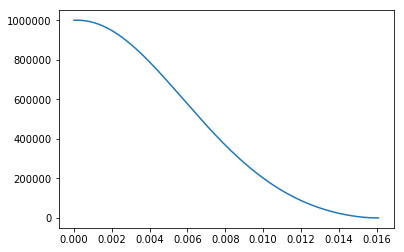

In [17]:
rs, Ms, lrhos = euler_integrate(M_rho_deriv_degen, 1e6)
plt.plot(rs, np.exp(lrhos))
plt.show()


**(a)** Modify some of the code below to help with this question. First, you will have to re-arrange (2) with the Fermi momentum being $m_e c$. 

In [ ]:
critical_density = INSERT_FORMULA_FOR_RHO
print('Critical density is: {:.2e}'.format(critical_density.cgs))
#Try 10 times lower than the critical density
r_in_rsun, M_in_Msun, rho = wd_structure(critical_density/10)
plt.plot(r_in_rsun, rho)
#Now 100 times lower.
r_in_rsun, M_in_Msun, rho = wd_structure(critical_density/100)
plt.plot(r_in_rsun, rho)

**(b)** Pen and paper plus quick calculation. [Hint: Equate electron pressure with gas pressure, with a mean molecular weight of 0.5]

**(c)** Here are some code snippets to help...

In [ ]:
rho_cs = np.linspace(np.log(LOWEST_DENSITY), np.log(HIGHEST_DENSITY), 30)
Ms = []
Rs = []
for rho_c in rho_cs:
    r_in_rsun, M_in_Msun, rho = wd_structure(rho_c)
    #for an array x, the value x[-1] is the last value in the array.
    Ms.append(INSERT_FINAL_M_HERE)
    Rs.append(INSERT_FINAL_R_HERE)

#Here is a plot with dots. Use xlabel and ylabel to label.
plt.plot(Ms, Rs, '.')